In [5]:
import sys, os
from fractions import Fraction
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from utils import get_chord_pitches
from constants import TRIAD_REDUCTION
import itertools
import operator
import numpy as np
from scipy.stats import ttest_ind


def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    return pd.concat([vc, vc / vc.sum()], axis=1, keys=['counts', 'fraction'])

In [6]:
data = '../Data/Beethoven_sonata_progression/'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time annotation1_chord annotation2_chord  sps  vl tbt  binary
01-1 0  0.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     1  0.25      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     2  0.50      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     3  0.75      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     4  1.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False

### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [7]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.558847
True     0.441153
Name: binary, dtype: float64


### Data Expansion

In [8]:
df = D#[D.binary] # select only diverging
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = D#[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)

In [9]:
def tbt_relaxed(set_a, set_b, as_distance=False):
    """Tone-by-tone but normalizing by 3 if a triad is involved.
    Returns 1 if a triad is contained in a tetrad.
    """
    n = min(len(set_a), len(set_b))
    overlap = len(set_a.intersection(set_b)) / n
    if as_distance:
        overlap = 1 - overlap
    return Fraction(overlap).limit_denominator(n)
    
def tbt_relaxed_cacheable(pc1, pc2, type1, type2, as_distance=False):
    a = set(get_chord_pitches(pc1, ChordType[type1], PitchType.MIDI) % 12)
    b = set(get_chord_pitches(pc2, ChordType[type2], PitchType.MIDI) % 12)
    return tbt_relaxed(a, b, as_distance=as_distance)

overlap = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2']).rename('overlap')
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv'),
                overlap,
               ], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  annotation1_chord annotation2_chord      sps  vl  tbt  binary  \
01-1 0   0.00       F_MINOR_inv0      F_MINOR_inv0  0.00000   0    0   False   
     12  2.25    C_MAJ_MIN7_inv1   C_MAJ_MIN7_inv1  0.00000   0    0   False   
     23  4.25       F_MINOR_inv0      F_MINOR_inv0  0.00000   0    0   False   
     30  5.25  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2  0.04917   2  3/8    True   
     37  6.25       F_MINOR_inv1      F_MINOR_inv1  0.00000   0    0   False   

        root1       type1 inv1  ...  pc1  root2     type2 inv2 triad2 tpc2  \
01-1 0      F       MINOR    0  ...    5      F     MINOR    0   True   -1   
     12     C    MAJ_MIN7    1  ...    0      C  MAJ_MIN7    1  False    0   
     23     F       MINOR    0  ...    5      F     MINOR    0   True   -1   
     30     E  DIMINISHED    1  ...    4      C  MAJ_MIN7    2  False    0   
     37     F       MINOR    1  ...    5      F     MINOR    1   True   -1   

         pc2  tpc_iv  pc_iv  overlap  
01-1 0     5       0      0        1  
     12    0       0      0        1  
     23    5       0      0        1  
     30    0       4      4        1  
     37    5       0      0        1  

[5 rows x 22 columns]

### Categorize divergences

**Create boolean masks**

In [10]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)
same_root = df.pc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2
diverging_inv = same_root & same_type & same_inversion.apply(lambda x: not x)
diverging_type = same_root & same_inversion
identical = same_root & same_type & same_inversion

In [11]:
ctgs = pd.Series(index=df.index, dtype='string', name='divergence')
triad_tetrad = same_root & same_type_reduced
triad_tetrad_root = overlap == 1
both_triads = df.triad1 & df.triad2
selectors = (
    ('identical',identical),
    ('inversion', diverging_inv),
    ('triad-tetrad', triad_tetrad&same_inversion),
    ('triad-tetrad&inversion', triad_tetrad&~same_inversion),
    ('type', diverging_type),
    ('type&inversion', same_root),
    ('triad-tetrad&root', triad_tetrad_root),
    ('no_overlap', overlap == 0),
    ('tetrads_sharing_3', overlap == 3/4),
    ('tetrads_sharing_2', overlap == 1/2),
    ('tetrads_sharing_1', overlap== 1/4),
    ('triads_sharing_2',  (overlap == Fraction(2,3)) & both_triads),
    ('triad_tetrad_sharing_2', (overlap == Fraction(2,3)) & ~both_triads),
    ('triads_sharing_1', (overlap == Fraction(1,3)) & both_triads),
    ('triad_tetrad_sharing_1', (overlap == Fraction(1,3)) & ~both_triads)
    
    )
for c, sel in selectors:
    ctgs = ctgs.where(ctgs.notna(), sel.map({True: c, False: pd.NA}))
## Now, fill in the uncategorized with the fraction of diverging notes
tbt_rel = transform(df, tbt_relaxed_cacheable, ['pc1', 'pc2', 'type1', 'type2'], as_distance=True)
ctgs = ctgs.where(ctgs.notna(), tbt_rel.astype(str))
vc(ctgs)

,counts,fraction
identical,4207,0.558847
inversion,944,0.125399
triads_sharing_1,547,0.072662
triad-tetrad,413,0.054862
triad_tetrad_sharing_1,290,0.038523
no_overlap,249,0.033077
triads_sharing_2,187,0.024841
triad_tetrad_sharing_2,174,0.023114
triad-tetrad&root,163,0.021652
triad-tetrad&inversion,122,0.016206


In [12]:
df['ctgs'] = ctgs

# Granularity

In [96]:
def split_list(my_list):
    """Returns list of lists of indices representing contiguous segments of identical elements"""
    return[[e[0] for e in d[1]] for d in itertools.groupby(enumerate(my_list), key=operator.itemgetter(1))]


In [97]:
#How many annotation sets are available
N_annotations = 2

#Initialize list of indices
same_granularity_list = list(range(len(df)))

for reference_annotation in range(N_annotations):
    #For each annotations set, find indices of labels with same granualrity and update same_granularity_list accordingly
    
    reference_annotation_name = 'annotation'+str(reference_annotation+1)+'_chord'
    non_repeated_labels = [i for sublist in filter(lambda x: len(x) == 1, split_list(df[reference_annotation_name])) for i in sublist]
    
    same_granularity_list = list(filter(lambda x: x in same_granularity_list, non_repeated_labels))

#Boolean feature of df: True = same granularity, False = different granularity (at least one annotation set changes faster than the others)
df['same_granularity'] = [i in same_granularity_list for i in range(len(df))]

In [98]:
ctgs_distribution_by_granularity = df[df.ctgs != 'identical'].groupby('same_granularity').ctgs.apply(vc)
ctgs_distribution_by_granularity 

counts  fraction
same_granularity                                         
False            inversion                  784  0.282217
                 triads_sharing_1           413  0.148668
                 triad-tetrad               355   0.12779
                 triad_tetrad_sharing_1     276  0.099352
                 no_overlap                 231  0.083153
                 triad_tetrad_sharing_2     150  0.053996
                 triads_sharing_2           149  0.053636
                 triad-tetrad&root          120  0.043197
                 triad-tetrad&inversion     117  0.042117
                 tetrads_sharing_3           64  0.023038
                 type                        62  0.022318
                 tetrads_sharing_1           32  0.011519
                 type&inversion              16   0.00576
                 tetrads_sharing_2            9   0.00324
True             inversion                  160  0.294659
                 triads_sharing_1           134  0.246777
                 triad-tetrad                58  0.106814
                 triad-tetrad&root           43   0.07919
                 triads_sharing_2            38  0.069982
                 type                        25  0.046041
                 triad_tetrad_sharing_2      24  0.044199
                 no_overlap                  18  0.033149
                 triad_tetrad_sharing_1      14  0.025783
                 tetrads_sharing_3           12  0.022099
                 tetrads_sharing_1            7  0.012891
                 triad-tetrad&inversion       5  0.009208
                 tetrads_sharing_2            3  0.005525
                 type&inversion               2  0.003683

In [221]:

ctgs_distribution_by_granularity = data[data.ctgs != 'identical'].groupby('same_granularity').ctgs.apply(vc)

#COmpute difference false - true: higher values means that there is a larger proportion of this ctg of error in granularity mismatch than in granularity congruent labels
ctgs_distribution_by_granularity.reset_index().rename(columns = {'level_1':'ctgs'}).sort_values(by = ['same_granularity', 'ctgs']).groupby('ctgs').fraction.apply(list).apply(lambda x: x[0]-x[1])

ctgs
inversion                -0.012442
no_overlap                0.050004
tetrads_sharing_1        -0.001372
tetrads_sharing_2        -0.002285
tetrads_sharing_3         0.000939
triad-tetrad              0.020976
triad-tetrad&inversion    0.032909
triad-tetrad&root        -0.035993
triad_tetrad_sharing_1    0.073569
triad_tetrad_sharing_2    0.009797
triads_sharing_1         -0.098109
triads_sharing_2         -0.016346
type                     -0.023722
type&inversion            0.002076
Name: fraction, dtype: float64

In [222]:

def ctgs_distribution_differences(data):
    """COmpute difference false - true: higher values means that there is a larger proportion of this ctg of error in granularity mismatch than in granularity congruent labels"""
    
    #Exclude identical labels (no error)
    ctgs_distribution_by_granularity = data[data.ctgs != 'identical'].groupby('same_granularity').ctgs.apply(vc)
    
    return ctgs_distribution_by_granularity.reset_index().rename(columns = {'level_1':'ctgs'}).sort_values(by = ['same_granularity', 'ctgs']).groupby('ctgs').fraction.apply(list).apply(lambda x: x[0]-x[1])
    
    

In [228]:
N_shuffles = 1000

ctgs_differences_bootstrap = ctgs_distribution_differences(df)
for n in range(N_shuffles):
    new_dataset = df.copy()
    new_dataset['same_granularity'] = np.random.permutation(df.same_granularity)
    
    ctgs_differences_bootstrap = pd.concat([ctgs_differences_bootstrap, ctgs_distribution_differences(new_dataset)], axis = 1)
    
ctgs_differences_bootstrap = ctgs_differences_bootstrap

In [229]:
ctgs_differences_bootstrap

,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction,...,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction,fraction
ctgs,,,,,,,,,,,,,,,,,,,,,
inversion,-0.012442,-0.020582,-0.008383,-0.025584,-0.025610,0.039215,0.019978,0.009743,-0.008892,0.010551,...,0.002121,-0.001583,-0.009415,-0.012913,0.024264,-0.021073,-0.029781,0.016028,-0.002822,-0.004067
no_overlap,0.050004,0.012560,-0.001443,0.009888,-0.000528,0.004017,-0.003071,0.010389,-0.000163,0.000020,...,-0.001386,-0.004341,-0.007970,-0.002702,-0.013815,0.018301,0.004524,-0.016729,-0.001837,-0.013282
tetrads_sharing_1,-0.001372,0.001555,0.006531,0.002090,-0.004293,0.000335,-0.004908,-0.000842,0.000063,-0.000554,...,0.002511,0.007684,-0.000009,-0.001175,0.005108,0.004505,-0.001829,0.001555,-0.004308,-0.002783
tetrads_sharing_2,-0.002285,-0.000836,-0.002023,-0.000665,-0.000759,0.001605,-0.003394,0.000398,0.001526,-0.003165,...,0.002749,0.001613,0.003954,-0.004598,-0.000872,-0.001884,0.000467,-0.000836,-0.001981,-0.000669
tetrads_sharing_3,0.000939,-0.002852,-0.016065,0.001862,0.009805,-0.011394,-0.004759,0.000893,-0.000944,-0.002203,...,-0.004615,0.005745,-0.004759,0.003924,0.000587,-0.006669,-0.005967,0.002030,0.000036,0.000620
triad-tetrad,0.020976,-0.012284,0.011953,0.003230,-0.002377,-0.008623,-0.008635,0.001594,-0.016434,0.008266,...,0.006817,-0.016858,-0.000062,-0.011693,0.001147,0.026159,0.033228,-0.001301,-0.020795,-0.006638
triad-tetrad&inversion,0.032909,0.000047,0.000361,0.005386,0.005678,-0.007275,0.000192,0.002621,0.010207,0.001075,...,-0.000807,-0.002303,-0.003482,0.002820,0.008240,0.004127,-0.017363,0.003708,-0.008979,-0.004376
triad-tetrad&root,-0.035993,0.001463,0.006757,-0.003566,0.008564,-0.009520,-0.004873,0.002862,0.005221,-0.009335,...,0.002774,0.006463,0.009823,-0.003406,-0.006345,-0.002411,-0.002274,-0.000977,0.004852,0.009736
triad_tetrad_sharing_1,0.073569,0.012755,-0.001142,-0.000279,0.007229,-0.014092,0.013908,-0.002788,-0.008819,-0.007956,...,0.008313,-0.000455,0.011459,-0.001584,-0.017405,-0.011317,0.019612,-0.005550,0.011994,0.010548


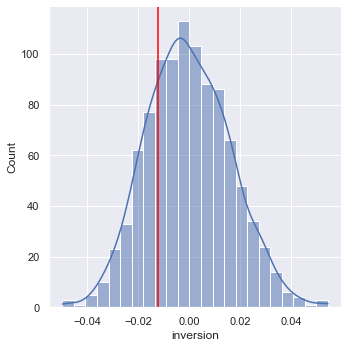

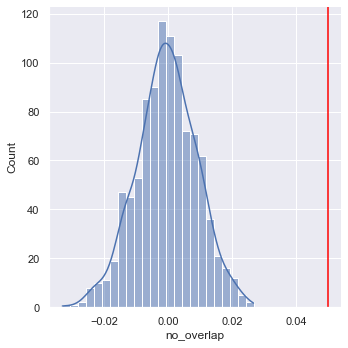

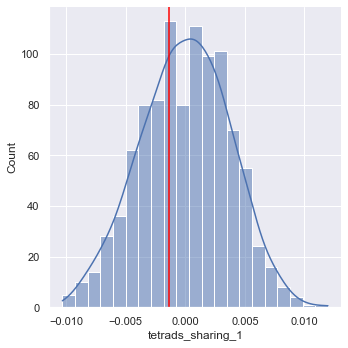

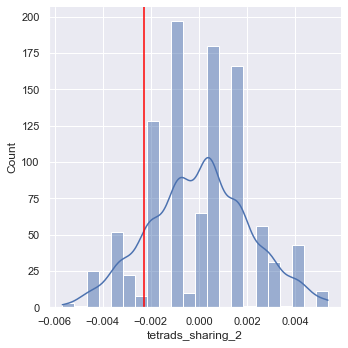

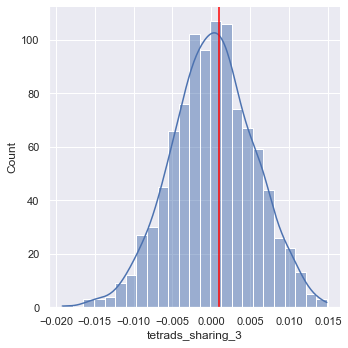

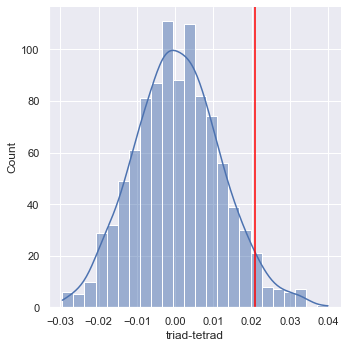

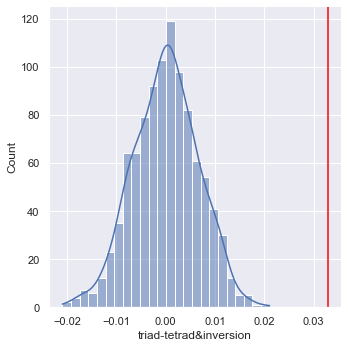

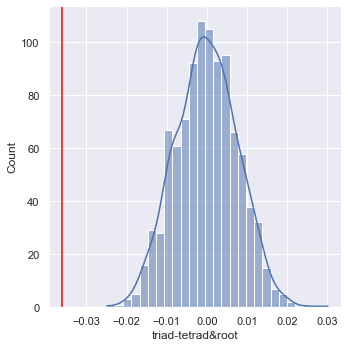

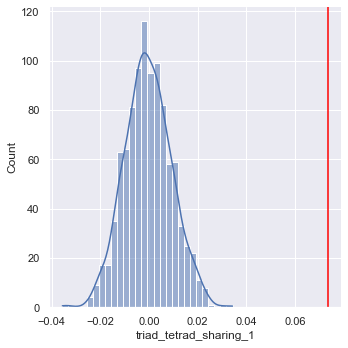

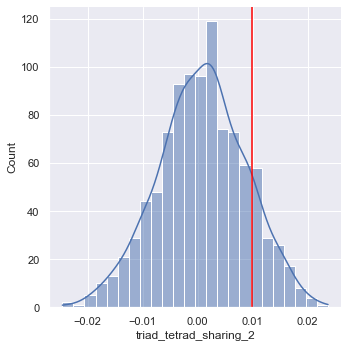

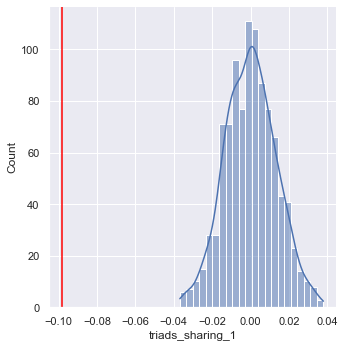

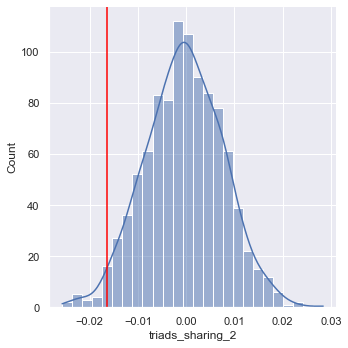

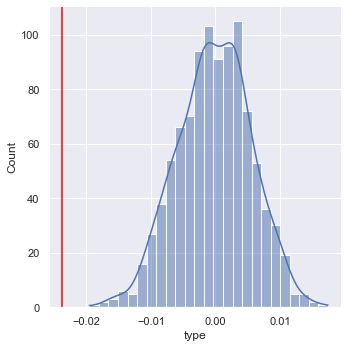

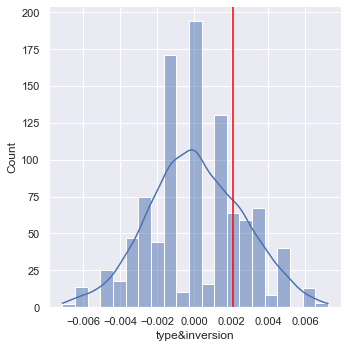

In [230]:
for ctg in ctgs_differences_bootstrap.index:
    
    sns.displot(ctgs_differences_bootstrap.loc[ctg][1:], kde = True)
    plt.axvline(x=ctgs_differences_bootstrap.loc[ctg][0], color='red', linestyle='-')

## Is SPS the same in errors with granularity mismatch vs. errors with same granularity?

<AxesSubplot:xlabel='same_granularity', ylabel='sps'>

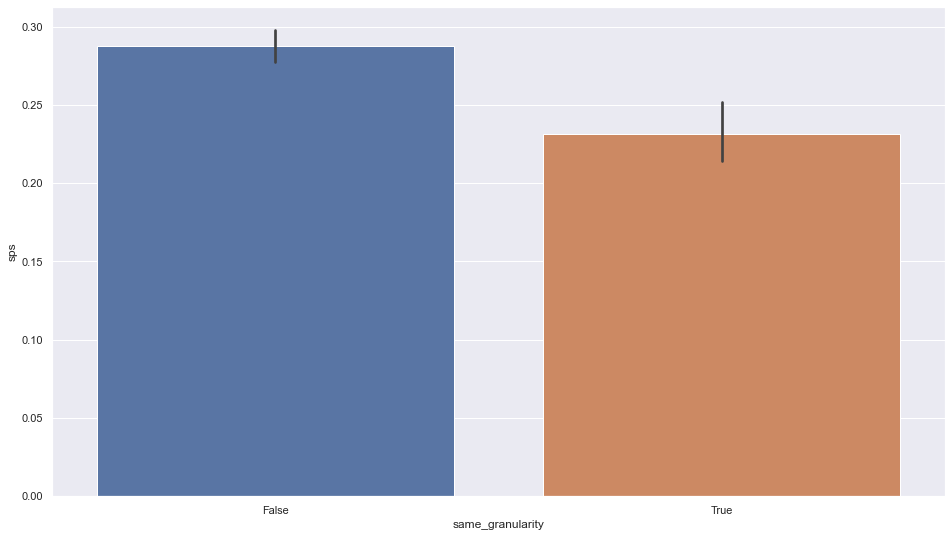

In [62]:
sns.barplot(data = df[df.ctgs != 'identical'], x = 'same_granularity', y = 'sps')

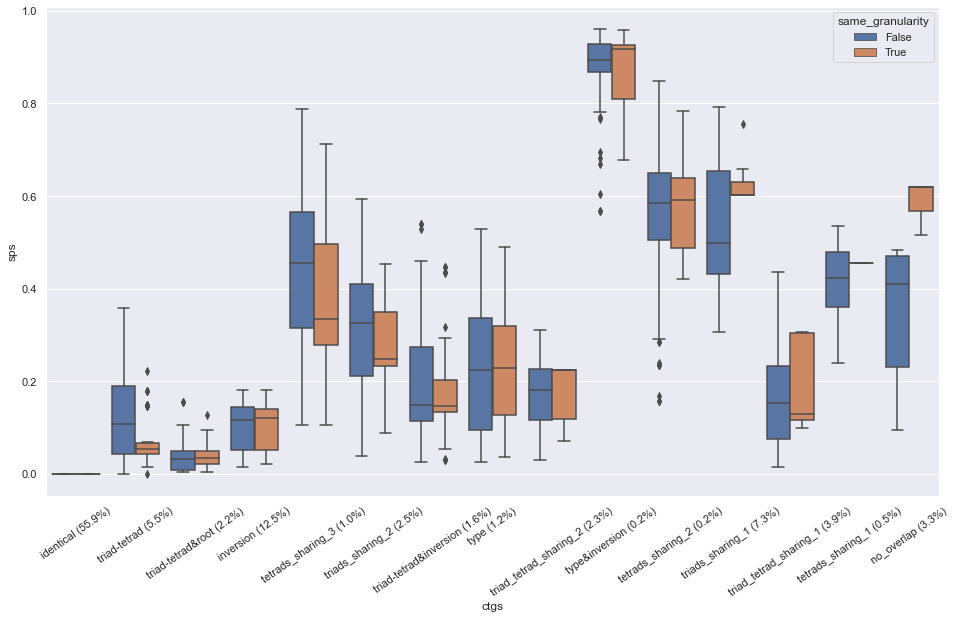

In [59]:
order_by_median = df.groupby('ctgs').sps.median().sort_values().index.to_list()
labels = [f"{l} ({df.ctgs.value_counts(normalize=True)[l]:.1%})" for l in order_by_median]
sns.set(rc={"figure.figsize":(16, 9)})
ax = sns.boxplot(data = df, x = 'ctgs', y = 'sps', hue = 'same_granularity')
ax.set_xticklabels(labels)
plt.xticks(rotation=35)
#plt.savefig('../figures/categories_sps.png', bbox_inches='tight')
plt.show()



In [56]:
pd.DataFrame(df.groupby(['ctgs', 'same_granularity']).sps.apply(list)).reset_index().groupby('ctgs').sps.apply(list).apply(lambda x: ttest_ind(x[0], x[1]))



ctgs
identical                                                  (nan, nan)
inversion                 (0.0043220542868407825, 0.9965524254440156)
no_overlap                   (0.6486838858056496, 0.5171453599124766)
tetrads_sharing_1          (-1.8005370098629636, 0.07993233734643294)
tetrads_sharing_2             (-2.843446785111057, 0.017444993041095)
tetrads_sharing_3           (-0.8082366584370023, 0.4215450807910418)
triad-tetrad               (-2.0335857402736117, 0.04263526887691681)
triad-tetrad&inversion      (0.12466894145475964, 0.9009942484361322)
triad-tetrad&root         (3.0766226855484837, 0.0024609307704961266)
triad_tetrad_sharing_1    (-0.026378880502513843, 0.9789734078151384)
triad_tetrad_sharing_2       (1.450712110756808, 0.14868129167635707)
triads_sharing_1           (3.943551081491933, 9.075941695510723e-05)
triads_sharing_2            (0.8348715291723042, 0.40486687402131816)
type                       (-0.47341662889937053, 0.6371295855490489)
type&inversion 

Some categories of disagreement are characterized by different degrees of SPS when they occur in the context of granularity mismatch compared to when they occur in passages where annotators adopt the same granularity.